In [19]:
# Stock Price Prediction with LSTM - Enhanced Version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import array

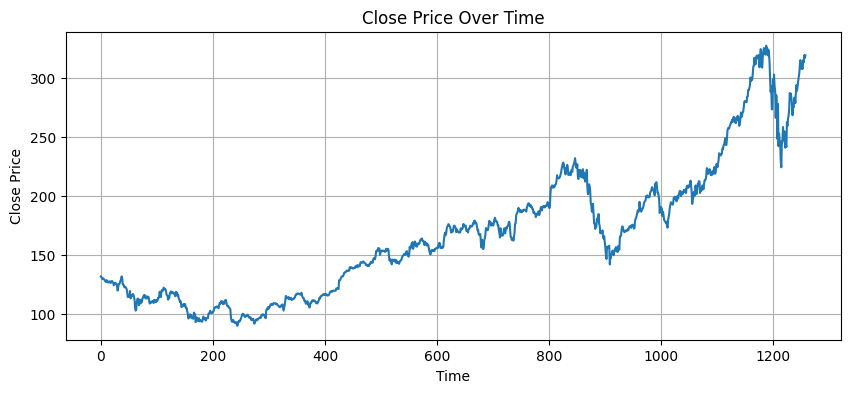

In [20]:
# =========================
# 1. Load and Inspect Data
# =========================
df = pd.read_csv('AAPL.csv')
df.head()

# Optional: Convert date column to datetime if available and sort
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')

# Plotting raw close price
plt.figure(figsize=(10, 4))
plt.plot(df['close'])
plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [21]:
# =========================
# 2. Feature Selection & Scaling
# =========================
df1 = df[['close']]
scaler = MinMaxScaler(feature_range=(0, 1))
df1_scaled = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [22]:
# =========================
# 3. Train-Test Split
# =========================
training_size = int(len(df1_scaled) * 0.65)
test_size = len(df1_scaled) - training_size
train_data = df1_scaled[0:training_size, :]
test_data = df1_scaled[training_size:len(df1_scaled), :1]

In [23]:
# =========================
# 4. Data Preparation Function
# =========================
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [25]:
# =========================
# 5. Model Building
# =========================
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 3s 290ms/step - loss: 5.4697e-04 - val_loss: 0.0031
Epoch 2/100
12/12 [==============================] - 4s 304ms/step - loss: 5.6357e-04 - val_loss: 0.0031
Epoch 3/100
12/12 [==============================] - 3s 233ms/step - loss: 5.7200e-04 - val_loss: 0.0034
Epoch 4/100
12/12 [==============================] - 3s 247ms/step - loss: 5.5410e-04 - val_loss: 0.0035
Epoch 5/100
12/12 [==============================] - 3s 249ms/step - loss: 5.1495e-04 - val_loss: 0.0035
Epoch 6/100
12/12 [==============================] - 2s 165ms/step - loss: 5.5628e-04 - val_loss: 0.0028
Epoch 7/100
12/12 [==============================] - 4s 341ms/step - loss: 5.2285e-04 - val_loss: 0.0034
Epoch 8/100
12/12 [==============================] - 2s 176ms/step - loss: 5.6036e-04 - val_loss: 0.0028
Epoch 9/100
12/12 [==============================] - 2s 145ms/step - loss: 4.8674e-04 - val_loss: 0.0025
Epoch 10/100
12/12 [==============================] - 3

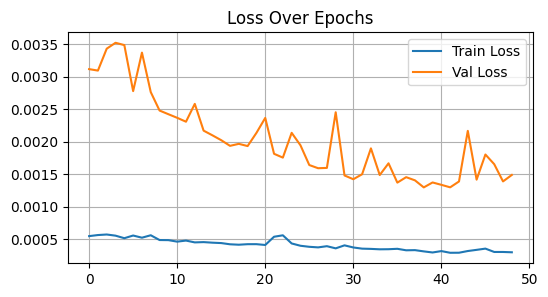

In [28]:
# =========================
# 6. Train the Model
# =========================
history = model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64,
                    verbose=1, callbacks=[early_stop, checkpoint])

# Plot training vs validation loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.grid(True)
plt.show()

In [29]:
# =========================
# 7. Predictions
# =========================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform ground truth
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
ytest_inv = scaler.inverse_transform(ytest.reshape(-1, 1))

11/11 [==============================] - 1s 108ms/step


In [30]:
# =========================
# 8. Evaluation Metrics
# =========================
def evaluate(y_true, y_pred):
    print("RMSE:", math.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate(y_train_inv, train_predict)
evaluate(ytest_inv, test_predict)

RMSE: 3.8396139517907963
MAE: 2.842539652819074
R2 Score: 0.9858610124263915
RMSE: 9.142235841841678
MAE: 7.076831489114198
R2 Score: 0.9640826790990148


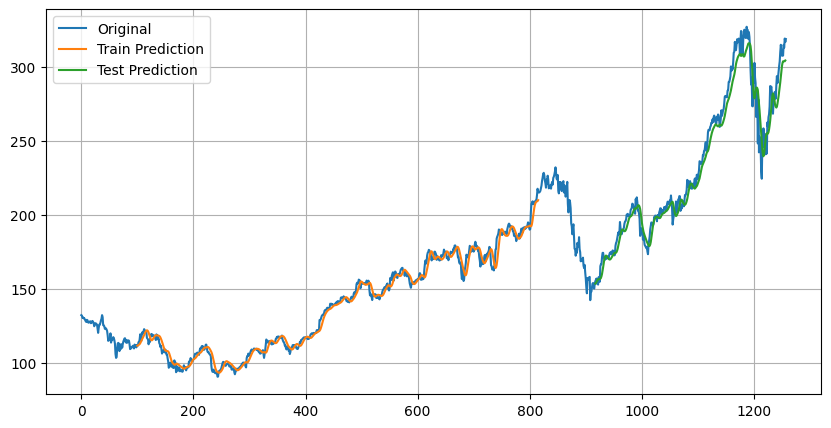

In [31]:
# =========================
# 9. Plotting predictions
# =========================
look_back = 100
trainPredictPlot = np.empty_like(df1_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1_scaled)-1, :] = test_predict

plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(df1_scaled), label='Original')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.grid(True)
plt.show()

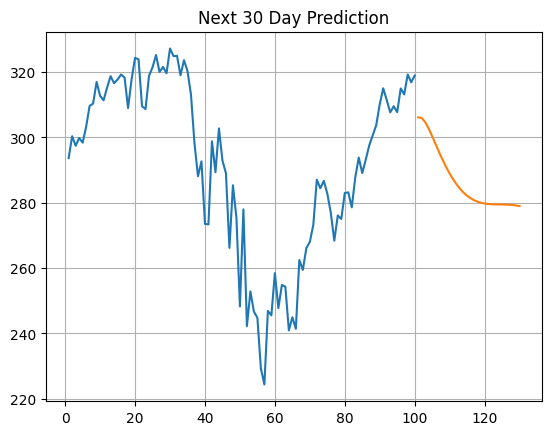

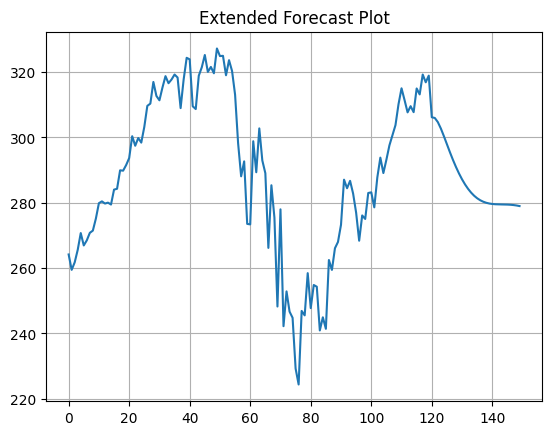

In [32]:
# =========================
# 10. Forecast Next 30 Days
# =========================
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    x_input = np.array(temp_input[-100:]).reshape(1, 100, 1)
    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    lst_output.append(yhat[0][0])

# Plot future predictions
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

plt.plot(day_new, scaler.inverse_transform(df1_scaled[-100:]))
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)))
plt.title("Next 30 Day Prediction")
plt.grid(True)
plt.show()

# Append forecast to original and plot
df3 = df1_scaled.tolist()
df3.extend(np.array(lst_output).reshape(-1, 1))
df3 = scaler.inverse_transform(df3)
plt.plot(df3[-150:])
plt.title("Extended Forecast Plot")
plt.grid(True)
plt.show()